# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 16, 18, 19, and ML communication 

**Due date: April 08, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 16, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads pre-trained word vectors trained on Wikipedia. (The vectors are created using an algorithm called GloVe.) To run the code, you'll need `gensim` package for that in your cpsc330 conda environment, which you can install as follows. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the word vectors. 

**Your tasks:**

1. Calculate cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

In [6]:
# adopted from lecture 16
for pair in word_pairs:
    print(
        "The similarity between %s and %s is %0.3f"
        % (pair[0], pair[1], glove_wiki_vectors.similarity(pair[0], pair[1]))
    )

The similarity between coast and shore is 0.700
The similarity between clothes and closet is 0.546
The similarity between old and new is 0.643
The similarity between smart and intelligent is 0.755
The similarity between dog and cat is 0.880
The similarity between tree and lawyer is 0.077


2. The similarities in general make sense, that words with the same categories (dog&cat) and similar meanings (coast&shore) have higher similarities while those with irrelevant context have lower similarity (tree&lawyer)

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 16 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class in these embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in them. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use them in your models. 

In [7]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    print(model)
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.similarity("white", "rich")

0.447236

In [9]:
glove_wiki_vectors.similarity("black", "rich")

0.51745194

In [10]:
analogy("man", "technician", "woman")

man : technician :: woman : ?


,Analogy word,Score
0,nurse,0.649846
1,paramedic,0.591545
2,dentist,0.569809
3,technologist,0.558359
4,therapist,0.558029
5,pharmacist,0.557814
6,technicians,0.554895
7,instructor,0.551818
8,nursing,0.550574
9,paralegal,0.548141


In [11]:
glove_wiki_vectors.similarity("man", "violent")

0.44489938

In [12]:
glove_wiki_vectors.similarity("woman", "violent")

0.35491282

1. Using pre-trained work embedding models might introduce even more gender-stereotype, or even discrimination. Say on a e-shop platform like Amazon, if the user is male, the platform recommends more manly stuff such as IT gadgets, work accessories but for female, the platform recommends house making equipment such as plates and sponge etc. This reinforces the gender stereotype that man should do work and women should do house work, which is not necessarily the case in modern world.
2. I used both the analogy and similarity functions and find that generally speaking, there is stereotype over people's careers and their genders - for men it's more technical and engineering, while for women, their industries are classified as medical-related fields which involve more caring of others.
3. I do observe the same gender stereotype as we have in class - about the careers of different genders. About the bias of violence between man and women.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's unlikely to be present in the vocabulary (e.g., the word "cpsc330"). 

In [13]:
glove_wiki_vectors["cpsc330"]

KeyError: "Key 'cpsc330' not present"

1. It does not contain all words in English language. Because there are always some new funky words or abbreviations over time. If we try to get a word vector that's unlikely to be present in the vocabulary, I think it might crash because we don't have that in our vocab.

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

We will be using spaCy in this exercise. If you do not have spaCy in your course environment, here is how you can install it.  

```
> conda activate cpsc330
> conda install -c conda-forge spacy
```

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment. 
```
python -m spacy download en_core_web_md
```

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train logistic regression with bag-of-words features and show classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and show classification report on the test set. (You can find an example of extracting average embedding features using spaCy in [lecture 16](https://ubc-cs.github.io/cpsc330/lectures/16_natural-language-processing.html#sentiment-classification-using-average-embeddings).)  
3. Discuss your results. Which model is performing well. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 



In [14]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2.0,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1.0,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1.0,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1.0,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1.0,bonding,bonding


In [15]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [16]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [17]:
import spacy

nlp = spacy.load("en_core_web_md")

from sklearn.metrics import (
    classification_report
)

In [18]:
# 1. Train logistic regression with bag-of-words features and show classification report on the test set.
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe.named_steps["countvectorizer"].fit(X_train)
X_train_transformed = pipe.named_steps["countvectorizer"].transform(X_train)
print("Data matrix shape:", X_train_transformed.shape)
pipe.fit(X_train, y_train)
print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Data matrix shape: (8736, 7578)
Train accuracy 0.96
Test accuracy 0.81


In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

                  precision    recall  f1-score   support

     achievement       0.77      0.88      0.82      1138
       affection       0.90      0.92      0.91      1254
         bonding       0.93      0.85      0.89       434
enjoy_the_moment       0.57      0.52      0.54       416
        exercise       0.83      0.53      0.65        73
         leisure       0.75      0.65      0.70       369
          nature       0.77      0.38      0.51        60

        accuracy                           0.81      3744
       macro avg       0.79      0.68      0.72      3744
    weighted avg       0.81      0.81      0.81      3744



In [20]:
# 2. Train logistic regression with average embedding representation extracted using spaCy and show classification report on the test set.
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])
lgr = LogisticRegression(max_iter=1000)
print("Data matrix shape:", X_train_embeddings.shape)
lgr.fit(X_train_embeddings, y_train)
print("Train accuracy {:.2f}".format(lgr.score(X_train_embeddings, y_train)))
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

Data matrix shape: (8736, 300)
Train accuracy 0.84
Test accuracy 0.80


In [21]:
print(classification_report(y_test, lgr.predict(X_test_embeddings)))

                  precision    recall  f1-score   support

     achievement       0.77      0.87      0.82      1138
       affection       0.87      0.91      0.89      1254
         bonding       0.85      0.78      0.81       434
enjoy_the_moment       0.58      0.51      0.54       416
        exercise       0.94      0.62      0.74        73
         leisure       0.81      0.63      0.71       369
          nature       0.73      0.53      0.62        60

        accuracy                           0.80      3744
       macro avg       0.79      0.69      0.73      3744
    weighted avg       0.80      0.80      0.80      3744



3. It seems that both models are pretty close in terms of test accuracy (0.81 vs 0.80). But I would say logit with average embedding is better as the train and test scores are close (which means there is no overfitting). Moreover, I think logit with average embedding is more interpretable because the number of features is greatly smaller (300 < 7578)
4. As we already have a pre-trained model as our starting point, supposedly it should take us lesser time to train compared with bag-of-words model. Moreover, we benefit from less overfitting here.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [22]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [23]:
df.shape

(18249, 13)

In [24]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [25]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~3 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [26]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [27]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain is Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [28]:
train_df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15436,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico
15437,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico
15438,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico
15439,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico


For "region" categorical feature, we should have separate measurements because the prices of avocado should be quite different in different regions because of the temperature, weather, and people's demand for them. Also, the same goes with "type" categorical feature, because both "organic" and "conventional" avocado should have different groups of target consumers.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

In [29]:
regions = df["region"].unique()
types = df["type"].unique()
print(regions)
print(types)

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']
['conventional' 'organic']


In [30]:
temp = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
temp

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


In [31]:
datesDiff = set()
for region in regions:
    for avocadoType in types:
        df_region = df[df["region"] == region]
        df_region_type = df_region[df_region["type"] == avocadoType]
        df_region_type_sorted_by_date = df_region_type.sort_values(by=["Date"]).reset_index(drop=True)
        prevDate = None
        for idx, date in enumerate(df_region_type_sorted_by_date["Date"]):
            if idx == 0: 
                prevDate = date
            else:
                datesDiff.add(str(date-prevDate))
        break
        
datesDiff

{'1001 days 00:00:00',
 '1008 days 00:00:00',
 '1015 days 00:00:00',
 '1022 days 00:00:00',
 '1029 days 00:00:00',
 '1036 days 00:00:00',
 '1043 days 00:00:00',
 '105 days 00:00:00',
 '1050 days 00:00:00',
 '1057 days 00:00:00',
 '1064 days 00:00:00',
 '1071 days 00:00:00',
 '1078 days 00:00:00',
 '1085 days 00:00:00',
 '1092 days 00:00:00',
 '1099 days 00:00:00',
 '1106 days 00:00:00',
 '1113 days 00:00:00',
 '112 days 00:00:00',
 '1120 days 00:00:00',
 '1127 days 00:00:00',
 '1134 days 00:00:00',
 '1141 days 00:00:00',
 '1148 days 00:00:00',
 '1155 days 00:00:00',
 '1162 days 00:00:00',
 '1169 days 00:00:00',
 '1176 days 00:00:00',
 '119 days 00:00:00',
 '126 days 00:00:00',
 '133 days 00:00:00',
 '14 days 00:00:00',
 '140 days 00:00:00',
 '147 days 00:00:00',
 '154 days 00:00:00',
 '161 days 00:00:00',
 '168 days 00:00:00',
 '175 days 00:00:00',
 '182 days 00:00:00',
 '189 days 00:00:00',
 '196 days 00:00:00',
 '203 days 00:00:00',
 '21 days 00:00:00',
 '210 days 00:00:00',
 '217 da

We can see not all data have equally spaced time. Some of them are spaced in 994 days and some (I guess most, by eyes) spaced between 7 days.

<br><br>

### 2.3
rubric={points:4}

In the Rain is Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [32]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

I don't think all regions are distinct. As one can see above, regions such as "TotalUS", "West", "California", "SanDiego" and "Sanfrancisco" are overlapped. Because San Diego and San Francisco are both in California and therefore in the US.

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 18, with some improvements.

In [33]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [34]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [35]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [36]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [37]:
def SST(averagePrices):
    sst = 0
    mean = averagePrices.mean()
    for price in averagePrices:
        sst += ((price-mean)**2)
    return sst

def SSR(averagePrices):
    ssr = 0
    for idx, price in enumerate(averagePrices):
        if idx == len(averagePrices) - 1: break
        ssr += ((price-averagePrices[idx+1])**2)
    return ssr

averagePrices = test_df["AveragePrice"]
sst = SST(averagePrices)
ssr = SSR(averagePrices.array)
r_square = (1 - ssr/sst)
r_square

0.5870824178542232

I get a r-square of 0.59

<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> Because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

In [38]:
#adopted from lecture 18
from sklearn.ensemble import RandomForestRegressor

numeric_features = [
    "AveragePrice",
    "Total Volume",
    "4046",
    "4225",
    "4770",
    "Total Bags",
    "Small Bags",
    "Large Bags",
    "XLarge Bags",
]
categorical_features = [
    "region",
    "type",
    "Month"
]
drop_features = [
    "Date",
    "year",
    "AveragePriceNextWeek"
]

def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
):

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="?"),
        OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names()
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

def score_rf_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    rf_pipe = make_pipeline(preprocessor, RandomForestRegressor())
    rf_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(rf_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(rf_pipe.score(test_df, y_test)))

In [39]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))
train_df[["Date", "Month"]].sort_values(by="Month")

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, numeric_features, categorical_features + ["Month"], drop_features
)
score_rf_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Train score: 0.98
Test score: 0.76


In [40]:
def get_season(month):
    WINTER_MONTHS = ["June", "July", "August"]
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
)
coeff_df = score_rf_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Train score: 0.98
Test score: 0.76


I have only tried encoding the date into "month" and "season". It seems that they are both pretty close in terms of test score.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

1. Natural disasters such as Earthquake would happen randomly in times, which made the time series data unequally spaced.
2. Both would struggle and suffer, for example even if we encode our date in months/seasons/even years, some rare events happen very irregularly (such as meteor collision or glacial period. These time series data would still struggle with unequally spaced times because they could happen once a few hundred years or once a few thousands year. And lagged versions do not make sense as well because we never know how long should we lag for these. And perhaps their existence is just random in time.

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw5?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

1. One should be more interested to know when the customer will churn but not whether or not he or she will churn eventually. Because it might be more insightful for the company to know when they should do something to retain the customer. 
2. We don't have enough information to answer, because it could be like "the one who joined longer should still stay because he/she has already joined for a long time, there is no strong reason/motive that he/she will stop", "the one who joined longer should quit quicker because he has already been with it for a long time, might be he/she wants to try out something new"
3. that means a customer's will always stay with the service or will always not stay. And his/her probability to stay is NOT affected by the independent variables at all.

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side project on machine learning in a "blog post" or report format. It's fine if you just write it here in this notebook. Alternatively, you can publish your blog post publicly and include a link here. (See exercise 4.3.) The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

In [41]:
from IPython.display import Image



## My Blog
### Background of the Problem
From a credit card company's perspective, it is good to know what kinds of personal traits would lead to a client's default on credit loans - these could be his/her education, sex, age, income, marital status or others. And among these personal traits, which is/are the most important factor(s) that contribute to a client's default?


To address this problem, I referenced my materials from assignment 6 using a dataset of people's default of credit card from [Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset).
### The Data
As detailed out in assignment 6, the dataset contains 30000 examples and 24 features, which include but not limited to sex, education, age, marital status, history of payment (PAY), bill payment amount (BILL_AMT) and the amount of previous payment (PAY_AMT) etc.


All these data were collected in Taiwan from April 2005 to September 2005. ([Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset))


I used a 70% train-test split, which we mean we would have 21000 examples as our training data and 9000 examples as our test data. A first glance about the training data, we have a class imbalance here that most clients will not default (about 76% of the training examples), and only about a quarter of clients will default.

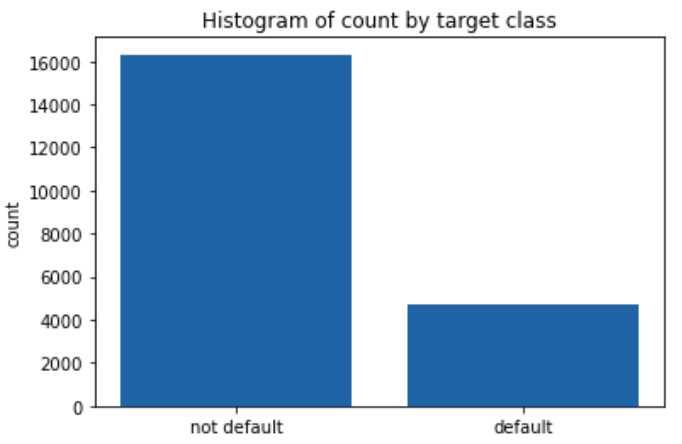

In [42]:
## Visualization 1.
Image("./visualizations/class_imbalance.png")

### The ML Models
To address the problem's objective, my analysis consists of the following components.

1. Data Preprocessing
2. Fitting into the Light GBM model
3. Hyperparameters Tuning

- Preprocessing: I first preprocessed the data using by classifying the features into numeric, categorical, and binary. Then I scale all the numeric features using StandardScaler() in scikit learn, and use OneHotEncoding on categorical and binary features, which basically translate one variable into multiple binary variables presenting each category of the original variable.

- LGBM: After preprocessing all the training data, I fit the 21000 examples into the LBGMClassifier model, which is a [decision-tree based model](https://en.wikipedia.org/wiki/LightGBM). The following is the output before parameter optimization, where we can see that the test score is 0.819

- Hyperparameters tuning: I used randomized search (RandomizedSearchCV()) to find out the best hyperparameters for the logistics regression model. The basic idea is to randomly search for hyperparameters that are useful to improve the test accuracy of the LGBM model. We see that the mean_test_score increases from 0.819 to 0.821 after parameter optimization

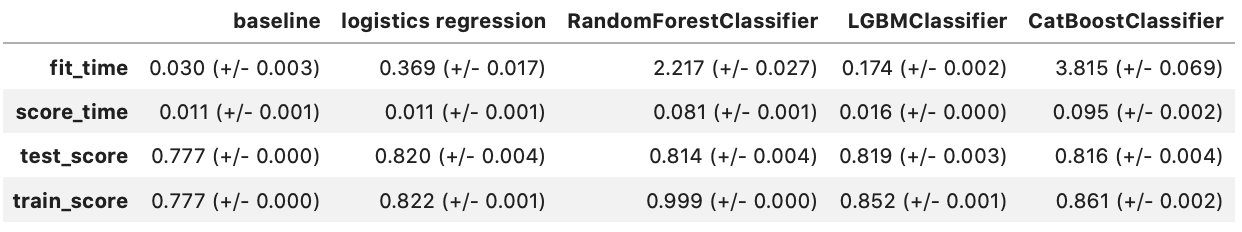

In [43]:
Image("./visualizations/model_without_param_optimization.png")

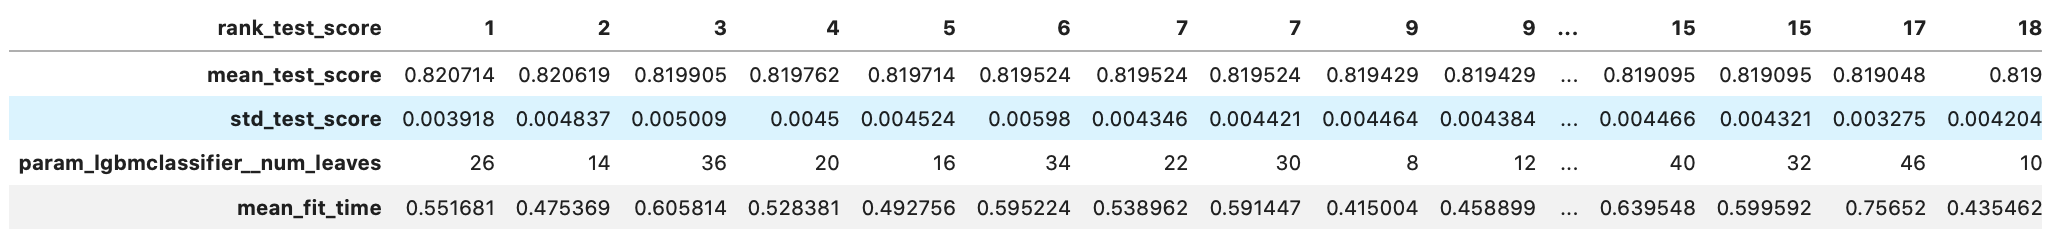

In [44]:
Image("./visualizations/model_output.png")

### Results

- One might be more interested in knowing what features would contribute more to whether a person will default or not, and here is my result. We can see that "PAY_0_2" has the largest weight among all, which means people who delayed to repay for 2 months as of September 2015 are much more likely to default. Interestingly, we see that other features such as "age", "education" are actually not as important as the repayment history of certain times.

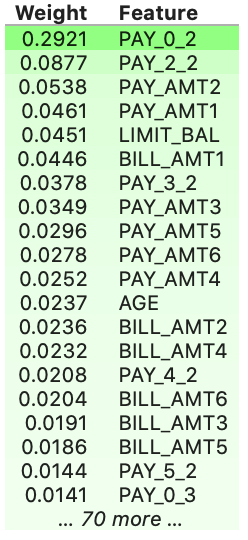

In [45]:
# Visualization 2.
Image("./visualizations/feature_importance.png")

- Another way to look at feature importance is by shap force plots. As we can see below, features that drive people to default their payment are in red whereas features that drive people not to default are in blue. Again, one can see that factors such as PAY_2_2 (Delay 2 months to repay as of Aug 2015), PAY_0_2 (Delay 2 months to repay as of Sep 2015) are the strongest factors that drive people to default. In short, people with poor repayment history are more likely to default.


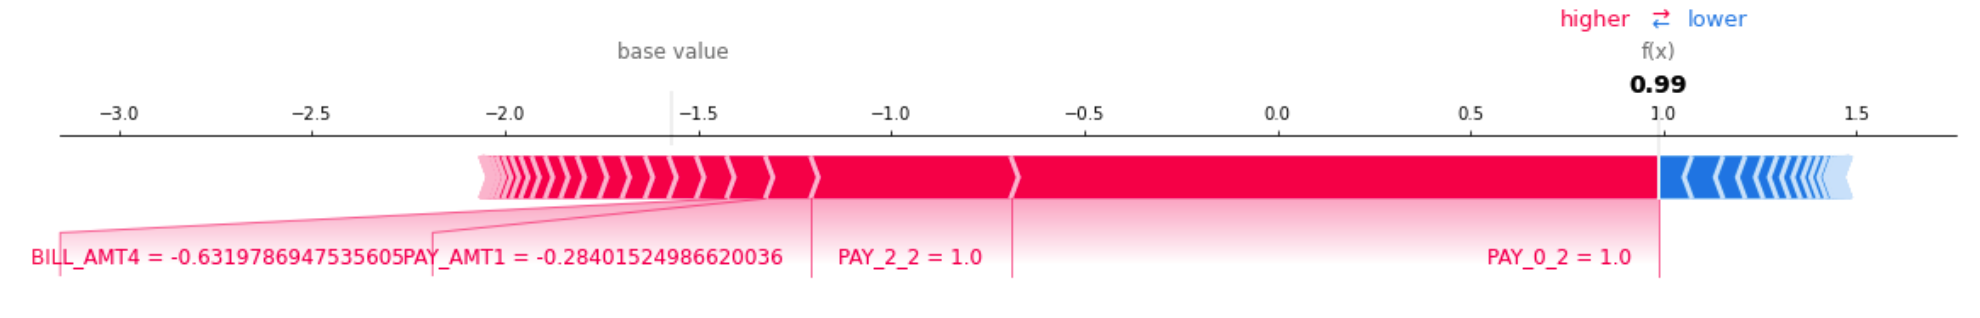

In [46]:
# Visualization 3.
Image("./visualizations/shap_ratio.png")

### Caveats
However, there are some caveats of my model and interpretations. Namely

- Lack of feature selection: I did not select the features that most useful in predicting whether or not one person will default for the sake of convenience, which could potentially lead my model to learn something that is useless. Currently I included every single feature in the dataset in training and testing the model. Perhaps a better way is to discard useless features.

- Lack of comparison with different other models: In here I only used LGBM model to present my result, perhaps a much more adoptable way is to try different models such as Random Forest, GBM, or ensemble models. The reason why I did not include all of them is because of time and length constraint. My result might have been more convincing if I tried different combinations of models (Ensembles)

- Lack of generalization: The data I used here only comes from Taiwan, in a half year time frame. Therefore my results would be specifically limited to understanding Taiwanese default patterns, but not all the people in the world. Moreover, even in the case of Taiwan, there might be more important features that are not in the dataset, but important enough to determine if one would default or not, say such as your current asset / your current net worth / the number of properties you are currently holding etc. Therefore, my results might not be convincing enough.

### Conclusion
This assignment consolidates my understanding towayds LGBM algorithm and helps me understand more about feature importance, and the topic itself is also interesting enough to let me understand Taiwanese default patterns. In short, what a great journey!

<br><br>

### 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

I applied "Approach from all angles" communication technique as you can see I displayed my model output with and without hyperparameter optimization to show the improved of test scores.

I am particularly satisfied with the Caveats part of my blog post because it lets me think deeper about what insufficiency my model has and what else I can improve to make a better result/presentation.

<br><br>

## (optional, not for marks) 4.3

Publish your blog post from 4.1 publicly using a tool like Hugo, or somewhere like medium.com, and paste a link here. Be sure to pick a tool in which code and code output look reasonable. This link could be a useful line on your resume!

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

The biggest takeaway for me is, as the name of this course suggests, how to apply different machine learning algorithms to solve real-world problems. Throughout the whole course, I learned more about the ML pipelines, from cleaning your data, preprocess your data, to finally combining different ML models to produce plausible results. These all are amazing to me because I never had the chance to practice before I took this course.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

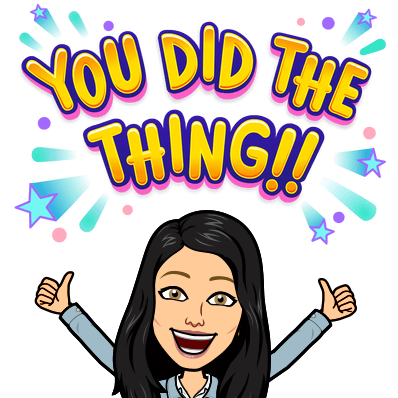

In [47]:
from IPython.display import Image

Image("eva-congrats.png")